In [12]:
import os
from re import I
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
from c3.optimizers.optimalcontrol import OptimalControl

import plotly.graph_objects as go
from plotting import *
from utilities_functions import *

import scipy as sp

In [13]:
qubit_levels = 3
qubit_frequency = 7.86e9
qubit_anharm = -264e6
qubit_t1 = 27e-6
qubit_t2star = 39e-6
qubit_temp = 50e-3

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency,min_val=1e9 ,max_val=8e9 ,unit='Hz 2pi'),
    anhar=Qty(value=qubit_anharm,min_val=-380e6 ,max_val=-120e6 ,unit='Hz 2pi'),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    t2star=Qty(value=qubit_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    temp=Qty(value=qubit_temp,min_val=0.0,max_val=0.12,unit='K')
)

resonator_levels = 12
resonator_frequency = 6.02e9
resonator_t1 = 235e-9
resonator_t2star = 39e-6
resonator_temp = 50e-3

parameters_resonator = {
    "freq": Qty(value=resonator_frequency,min_val=0e9 ,max_val=8e9 ,unit='Hz 2pi'),
    "t1": Qty(value=resonator_t1,min_val=100e-9,max_val=1e-6,unit='s'),
    "t2star": Qty(value=resonator_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    "temp": Qty(value=resonator_temp,min_val=0.0,max_val=0.12,unit='K')
}

#chip.ReadoutResonator(
resonator = chip.Resonator(
    name="R",
    desc="Resonator",
    hilbert_dim=resonator_levels,
    params=parameters_resonator
)

coupling_strength = 130e6
qr_coupling = chip.Coupling(
    name="Q-R",
    desc="coupling",
    comment="Coupling qubit and resonator",
    connected=["Q", "R"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

drive_qubit = chip.Drive(
    name="dQ",
    desc="Drive Q",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_resonator = chip.Drive(
    name="dR",
    desc="Drive R",
    comment="Drive line on Resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)


drives = [drive_qubit, drive_resonator]

model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, drive_resonator, qr_coupling]  # Interactions between components
)
model.set_dressed(False)
model.set_lindbladian(True)


In [14]:
sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "QuadraturesToValues": devices.QuadraturesToValues(name="quad_to_val", inputs=1, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ":["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"],
            "dR":["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"]
        }
    )

generator.devices["AWG"].enable_drag_2()

In [15]:
def calculateState(
    exp: Experiment,
    psi_init: tf.Tensor,
    sequence: List[str]
):

    """
    Calculates the state of system with time.

    Parameters
    ----------
    exp: Experiment,
        The experiment containing the model and propagators
    psi_init: tf.Tensor,
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state

    Returns
    -------
    psi_list: List[tf.Tensor]
        List of states
    """

    model = exp.pmap.model
    dUs = exp.partial_propagators
    if model.lindbladian:
        psi_t = tf_utils.tf_dm_to_vec(psi_init)
    else:
        psi_t = psi_init
    #psi_list = [psi_t]
    psi_list = []
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = tf.matmul(du, psi_t)
            psi_list.append(psi_t)

    return psi_list


def calculateExpectationValue(states, Op, lindbladian):
    expect_val = []
    for i in states:
        if lindbladian:
            expect_val.append(tf.linalg.trace(tf.matmul(Op, i)))
        else:
            expect_val.append(tf.matmul(tf.matmul(tf.transpose(i, conjugate=True), Op),i)[0,0])
    return expect_val



def frameOfDrive(exp, psi_list, freq_q, freq_r, spacing):
    model = exp.pmap.model
    aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)

    n = len(psi_list)

    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)

    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag, aQ)

    #dt = (exp.ts[spacing] - exp.ts[0]).numpy()
    #ts = np.linspace(0.0, dt*n, n)
    ts = exp.ts[::spacing]
    ts = tf.cast(ts, dtype=tf.complex128)
    
    I = tf.eye(len(aR), dtype=tf.complex128)
    
    psi_rotated = []
    
    for i in range(n):
        U = tf.linalg.expm(1j*2*np.pi*(freq_r*NR + freq_q*NQ)*ts[i])
        if model.lindbladian:
            U_dag = tf.linalg.expm(-1j*2*np.pi*(freq_r*NR + freq_q*NQ)*ts[i])
            rho_i = tf_utils.tf_vec_to_dm(psi_list[i])
            psi_rotated.append(tf.matmul(tf.matmul(U_dag, rho_i), U))    ## Check this. Now it is U_dag*rho*U but I think it should be U*rho*U_dag
        else:
            psi_rotated.append(tf.matmul(U, psi_list[i]))

    return psi_rotated



def frameOfDriveIdeal(exp, psi_list, freq_q, freq_r, spacing, drive_amp_q, drive_amp_r):
    model = exp.pmap.model
    aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)

    n = len(psi_list)

    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)
    
    I = tf.eye(len(aR), dtype=tf.complex128)

    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag, aQ)
    NQ = NQ + 0.5*qubit_anharm*tf.matmul(NQ - I, NQ)

    ts = exp.ts[::spacing]
    ts = tf.cast(ts, dtype=tf.complex128)
    
    drive_amp_q = drive_amp_q[::spacing]
    drive_amp_r = drive_amp_r[::spacing]

    drive_amp_q = tf.cast(drive_amp_q, dtype=tf.complex128)
    drive_amp_r = tf.cast(drive_amp_r, dtype=tf.complex128)


    psi_rotated = []
    
    for i in range(n):
        U = tf.linalg.expm(1j*2*np.pi*(drive_amp_r[i]*freq_r*NR + drive_amp_q[i]*freq_q*NQ)*ts[i])
        if model.lindbladian:
            #U_dag = tf.linalg.expm(-1j*2*np.pi*(freq_r*NR + freq_q*NQ)*ts[i])
            U_dag = tf.transpose(U, conjugate=True)
            rho_i = tf_utils.tf_vec_to_dm(psi_list[i])
            psi_rotated.append(tf.matmul(tf.matmul(U_dag, rho_i), U))    ## Check this. Now it is U_dag*rho*U but I think it should be U*rho*U_dag
        else:
            psi_rotated.append(tf.matmul(U, psi_list[i]))

    return psi_rotated


def plotIQ(
        exp: Experiment, 
        sequence: List[str], 
        annihilation_operator: tf.Tensor,
        drive_freq_q,
        drive_freq_r,
        spacing=100,
        usePlotly=False
):
    
    """
    Calculate and plot the I-Q values for resonator 

    Parameters
    ----------
    exp: Experiment,
 
    sequence: List[str], 

    annihilation_operator: tf.Tensor

    Returns
    -------
        
    """
    model = exp.pmap.model
    annihilation_operator = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    
    state_index = exp.pmap.model.get_state_index((0,0))
    psi_init_0 = [[0] * model.tot_dim]
    psi_init_0[0][state_index] = 1
    init_state_0 = tf.transpose(tf.constant(psi_init_0, tf.complex128))
    
    if model.lindbladian:
        init_state_0 = tf_utils.tf_state_to_dm(init_state_0)

    psi_list = calculateState(exp, init_state_0, sequence)
    psi_list = psi_list[::spacing]
    psi_list_0 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    expect_val_0 = calculateExpectationValue(psi_list_0, annihilation_operator, model.lindbladian)
    Q0 = np.real(expect_val_0)
    I0 = np.imag(expect_val_0)
    

    state_index = exp.pmap.model.get_state_index((1,0))
    psi_init_1 = [[0] * model.tot_dim]
    psi_init_1[0][state_index] = 1
    init_state_1 = tf.transpose(tf.constant(psi_init_1, tf.complex128))
    
    if model.lindbladian:
        init_state_1 = tf_utils.tf_state_to_dm(init_state_1)

    psi_list = calculateState(exp, init_state_1, sequence)
    psi_list = psi_list[::spacing]
    psi_list_1 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    expect_val_1 = calculateExpectationValue(psi_list_1, annihilation_operator, model.lindbladian)
    Q1 = np.real(expect_val_1)
    I1 = np.imag(expect_val_1)

    ts = exp.ts[::spacing]
    dist = []
    for t in range(len(ts)):
        dist.append(np.sqrt((Q0[t] - Q1[t])**2 + (I0[t] - I1[t])**2))
    
    if usePlotly:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = Q0, y = I0, mode = "lines", name="Ground state"))
        fig.add_trace(go.Scatter(x = Q1, y = I1, mode = "lines", name ="Excited state"))
        fig.show()
    #fig.write_image("Readout_IQ.png")
    else:
        plt.figure(dpi=100)
        plt.plot(Q0, I0, label="Ground state", linestyle='--', marker='o')
        plt.plot(Q1, I1, label="Excited state", linestyle='--', marker='o')
        plt.legend()
        plt.show()
    
    plt.figure(dpi=100)
    plt.plot(ts, dist)
    plt.show()




def plotIQIdeal(
        exp: Experiment, 
        sequence: List[str], 
        annihilation_operator: tf.Tensor,
        drive_freq_q,
        drive_freq_r,
        drive_amp_q,
        drive_amp_r,
        spacing=100,
        usePlotly=False
):
    
    """
    Calculate and plot the I-Q values for resonator 

    Parameters
    ----------
    exp: Experiment,
 
    sequence: List[str], 

    annihilation_operator: tf.Tensor

    drive_amp_q: List
    
    drive_amp_r: List

    Returns
    -------
        
    """
    model = exp.pmap.model
    annihilation_operator = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    
    state_index = exp.pmap.model.get_state_index((0,0))
    psi_init_0 = [[0] * model.tot_dim]
    psi_init_0[0][state_index] = 1
    init_state_0 = tf.transpose(tf.constant(psi_init_0, tf.complex128))
    
    if model.lindbladian:
        init_state_0 = tf_utils.tf_state_to_dm(init_state_0)

    psi_list = calculateState(exp, init_state_0, sequence)
    psi_list = psi_list[::spacing]
    #psi_list_0 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    psi_list_0 =  frameOfDriveIdeal(exp, psi_list, drive_freq_q, drive_freq_r, spacing, drive_amp_q, drive_amp_r)
    expect_val_0 = calculateExpectationValue(psi_list_0, annihilation_operator, model.lindbladian)
    Q0 = np.real(expect_val_0)
    I0 = np.imag(expect_val_0)
    

    state_index = exp.pmap.model.get_state_index((1,0))
    psi_init_1 = [[0] * model.tot_dim]
    psi_init_1[0][state_index] = 1
    init_state_1 = tf.transpose(tf.constant(psi_init_1, tf.complex128))
    
    if model.lindbladian:
        init_state_1 = tf_utils.tf_state_to_dm(init_state_1)

    psi_list = calculateState(exp, init_state_1, sequence)
    psi_list = psi_list[::spacing]
    #psi_list_1 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    psi_list_1 =  frameOfDriveIdeal(exp, psi_list, drive_freq_q, drive_freq_r, spacing, drive_amp_q, drive_amp_r)
    expect_val_1 = calculateExpectationValue(psi_list_1, annihilation_operator, model.lindbladian)
    Q1 = np.real(expect_val_1)
    I1 = np.imag(expect_val_1)

    ts = exp.ts[::spacing]
    dist = []
    for t in range(len(ts)):
        dist.append(np.sqrt((Q0[t] - Q1[t])**2 + (I0[t] - I1[t])**2))
    
    if usePlotly:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = Q0, y = I0, mode = "lines", name="Ground state"))
        fig.add_trace(go.Scatter(x = Q1, y = I1, mode = "lines", name ="Excited state"))
        fig.show()
    #fig.write_image("Readout_IQ.png")
    else:
        plt.figure(dpi=100)
        plt.plot(Q0, I0, label="Ground state", linestyle='--', marker='o')
        plt.plot(Q1, I1, label="Excited state", linestyle='--', marker='o')
        plt.legend()
        plt.show()
    
    plt.figure(dpi=100)
    plt.plot(ts, dist)
    plt.show()


    #final_state_0 = psi_list_0[-1]
    #final_state_1 = psi_list_1[-1]
    #if model.lindbladian:
    #    final_state_0 = tf_utils.tf_vec_to_dm(final_state_0)
    #    final_state_1 = tf_utils.tf_vec_to_dm(final_state_1)
    #
    #xvec = np.linspace(-10,10,100)
    #yvec = np.linspace(-10,10,100)
    #plotWignerFunction([final_state_0, final_state_1], xvec, yvec)




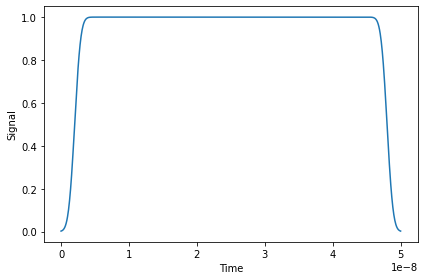

/home/ashutos/c3/c3/signal/gates.py:81: UserWarning: No ideal gate found for gate: Readout
  warnings.warn(f"No ideal gate found for gate: {key}")


In [19]:
qubit_freqs = model.get_qubit_freqs()
sideband = 50e6

Delta_1 = qubit_frequency - resonator_frequency
Delta_2 = (2 + qubit_anharm)*qubit_frequency
chi_0 = (coupling_strength**2)/Delta_1
chi_1 = (coupling_strength**2)/(Delta_2 - Delta_1)

#carriers = createCarriers([resonator_frequency+sideband - chi_1/2, resonator_frequency+sideband - chi_1/2], sideband)
carriers = createCarriers([qubit_frequency+sideband - chi_1/2, qubit_frequency+sideband - chi_1/2], sideband)



t_readout = 50e-9
t_total = 50e-9
sideband = 50e6


"""
readout_params = {
    "amp": Qty(value=0.1,min_val=0.0,max_val=100.0,unit="V"),
    "t_final": Qty(value=t_readout,min_val=0.5 * t_readout,max_val=1.5 * t_readout,unit="s"),
    "sigma": Qty(value=t_readout/5,min_val=t_readout/20,max_val=t_readout/2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

readout_pulse = pulse.Envelope(
    name="readout",
    desc="Gaussian pulse for readout",
    params=readout_params,
    shape=envelopes.gaussian_nonorm
)

"""
readout_params = {
    "amp": Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "t_down": Qty(value=t_readout-2.0e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_readout/2, unit="s"),
    "xy_angle": Qty(value=np.pi,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_total,min_val=0.1*t_total,max_val=1.5*t_total,unit="s")
}

readout_pulse = pulse.Envelope(
    name="readout-pulse",
    desc="Flattop pluse for SWAP gate",
    params=readout_params,
    shape=envelopes.flattop
)


tlist = np.linspace(0,t_total, 1000)
plotSignal(tlist, readout_pulse.shape(tlist, readout_pulse.params).numpy())

nodrive_pulse = pulse.Envelope(
    name="no_drive", 
    params={
        "t_final": Qty(
            value=t_total,
            min_val=0.5 * t_total,
            max_val=1.5 * t_total,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_pulse = copy.deepcopy(readout_pulse)
qubit_pulse.params["amp"] = Qty(value=2*np.pi*0,min_val=0.0,max_val=10.0,unit="V")
qubit_pulse.params["xy_angle"] = Qty(value=0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad")
resonator_pulse = copy.deepcopy(readout_pulse)
resonator_pulse.params["amp"] = Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V")
resonator_pulse.params["xy_angle"] = Qty(value=-np.pi,min_val=-np.pi,max_val=2.5 * np.pi,unit="rad")
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_total, channels=["dQ", "dR"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "dR")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "dR")

readout_gates = [Readout_gate]

In [20]:
coupling_strength/Delta_1

0.07065217391304347

In [21]:
parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

#model.use_FR = False
#exp.use_control_fields = False
model.set_lindbladian(False)
exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()

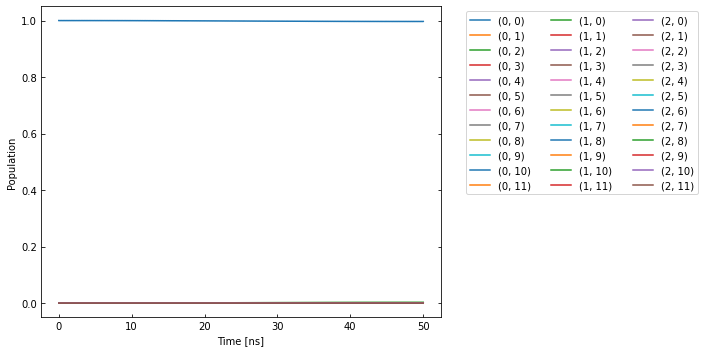

In [22]:
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

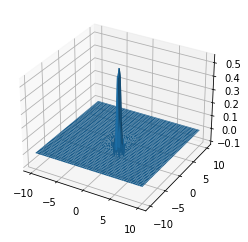

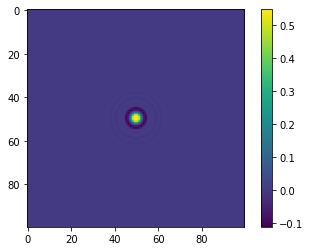

In [9]:
xvec = np.linspace(-10,10,100)
yvec = np.linspace(-10,10,100)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
plotWignerFunction([tf.matmul(unitaries["Readout[1]"], init_state)], xvec, yvec)

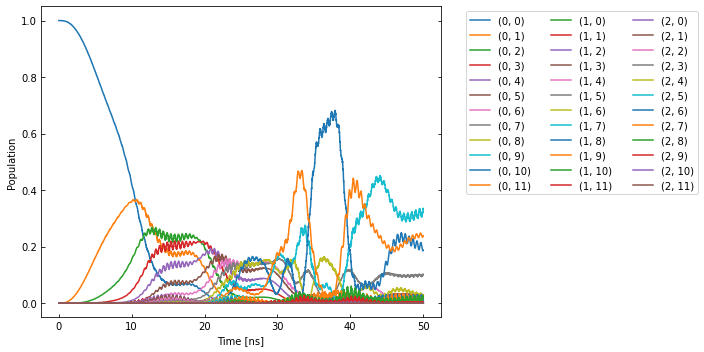

In [10]:
parameter_map.load_values("best_point_iq_opt2.txt")
exp = Exp(pmap=parameter_map)

model.set_lindbladian(False)
exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

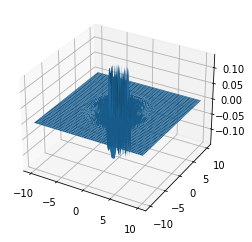

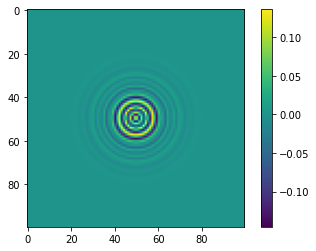

In [11]:
xvec = np.linspace(-10,10,100)
yvec = np.linspace(-10,10,100)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
plotWignerFunction([tf.matmul(unitaries["Readout[1]"], init_state)], xvec, yvec)

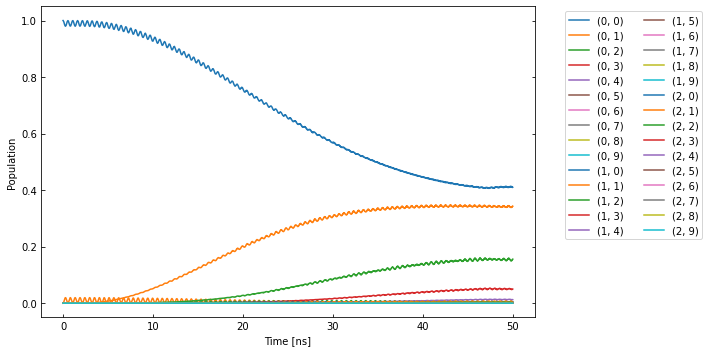

In [18]:
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

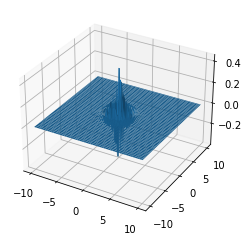

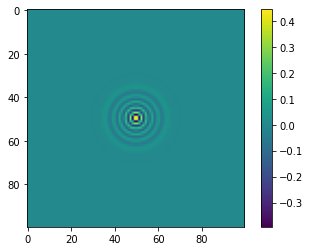

In [19]:
xvec = np.linspace(-10,10,100)
yvec = np.linspace(-10,10,100)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
plotWignerFunction([tf.matmul(unitaries["Readout[1]"], init_state)], xvec, yvec)

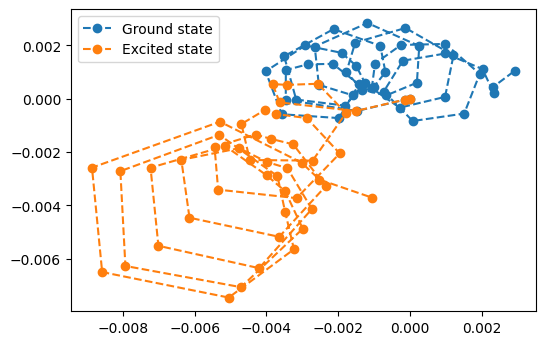

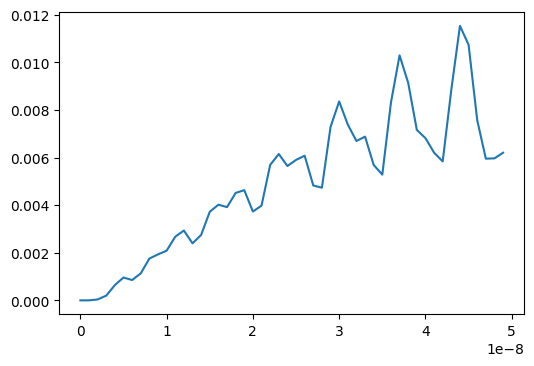

In [24]:
plotIQ(exp, sequence, model.ann_opers[1], qubit_frequency, qubit_frequency, spacing=100, usePlotly=False)

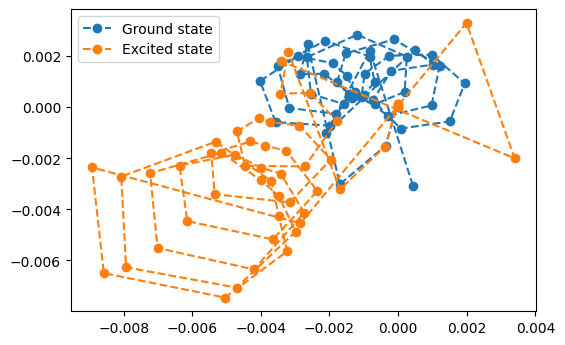

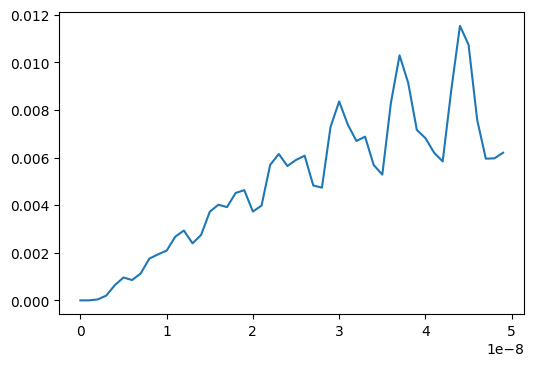

In [26]:
ts = exp.ts
drive_q_shape = qubit_pulse.shape(ts, qubit_pulse.params)
drive_r_shape = resonator_pulse.shape(ts, resonator_pulse.params)

plotIQIdeal(
    exp = exp, 
    sequence = sequence, 
    annihilation_operator= model.ann_opers[1], 
    drive_freq_q= qubit_frequency,
    drive_freq_r= qubit_frequency,
    drive_amp_q = drive_q_shape,
    drive_amp_r = drive_r_shape,
    spacing=100,
    usePlotly=False )

## Optimization

In [13]:
parameter_map.set_opt_map([
    [("Readout[1]", "dR", "carrier", "freq")],
    [("Readout[1]", "dR", "readout-pulse", "amp")],
    [("Readout[1]", "dR", "readout-pulse", "t_up")],
    [("Readout[1]", "dR", "readout-pulse", "t_down")],
    [("Readout[1]", "dR", "readout-pulse", "risefall")],
    [("Readout[1]", "dR", "readout-pulse", "xy_angle")],
    [("Readout[1]", "dR", "readout-pulse", "freq_offset")],
    [("Readout[1]", "dR", "readout-pulse", "delta")],
    [("Readout[1]", "dQ", "carrier", "freq")],
    [("Readout[1]", "dQ", "readout-pulse", "amp")],
    [("Readout[1]", "dQ", "readout-pulse", "t_up")],
    [("Readout[1]", "dQ", "readout-pulse", "t_down")],
    [("Readout[1]", "dQ", "readout-pulse", "risefall")],
    [("Readout[1]", "dQ", "readout-pulse", "xy_angle")],
    [("Readout[1]", "dQ", "readout-pulse", "freq_offset")],
    [("Readout[1]", "dQ", "readout-pulse", "delta")],
])

parameter_map.print_parameters()

psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))

psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))

freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max
}



opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.IQ_plane_distance,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":10},
    run_name="Readout_IQ",
    fid_func_kwargs={"params":fid_params}
)
exp.set_opt_gates(["Readout[1]"])
opt.set_exp(exp)

opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())

Readout[1]-dR-carrier-freq            : 6.070 GHz 2pi 
Readout[1]-dR-readout-pulse-amp       : 62.832 mV 
Readout[1]-dR-readout-pulse-t_up      : 2.000 ns 
Readout[1]-dR-readout-pulse-t_down    : 48.000 ns 
Readout[1]-dR-readout-pulse-risefall  : 1.000 ns 
Readout[1]-dR-readout-pulse-xy_angle  : -3.142 rad 
Readout[1]-dR-readout-pulse-freq_offset: -53.000 MHz 2pi 
Readout[1]-dR-readout-pulse-delta     : -1.000  
Readout[1]-dQ-carrier-freq            : 6.070 GHz 2pi 
Readout[1]-dQ-readout-pulse-amp       : 314.159 mV 
Readout[1]-dQ-readout-pulse-t_up      : 2.000 ns 
Readout[1]-dQ-readout-pulse-t_down    : 48.000 ns 
Readout[1]-dQ-readout-pulse-risefall  : 1.000 ns 
Readout[1]-dQ-readout-pulse-xy_angle  : -444.089 arad 
Readout[1]-dQ-readout-pulse-freq_offset: -53.000 MHz 2pi 
Readout[1]-dQ-readout-pulse-delta     : -1.000  

C3:STATUS:Saving as: /home/ashutos/Dropbox/FZJ To read/Thorge/Qubit_readout/Ashutosh_codes/output/Readout_IQ/2022_04_07_T_17_39_30/open_loop.log
0.5268816851194956

## Plotting Optimization run

In [ ]:
exp = Exp()
exp.read_config("qubit_reset_experiment_two_carriers.hjson")
pmap = exp.pmap
model = pmap.model
pmap.load_values("best_point.txt")

exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()

init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']

states_to_plot = [(0,1), (1,0), (0,2), (2,0), (1,1)]
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, states_to_plot=states_to_plot, usePlotly=False)


In [ ]:
tswap = 250e-9

exp = Exp()
exp.read_config("qubit_reset_experiment_two_carriers.hjson")
pmap = exp.pmap
model = pmap.model
pmap.load_values("best_point.txt")
ts = np.linspace(0, tswap, 10000)

pmap_dict = pmap.asdict()
Q_pulse1 = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ1"]["swap_pulse"]
R_pulse1 = pmap_dict["swap[0, 1]"]["drive_channels"]["dR1"]["swap_pulse"]

Qpulse_carrier1 = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ1"]["carrier"]
Rpulse_carrier1 = pmap_dict["swap[0, 1]"]["drive_channels"]["dR1"]["carrier"]

Qpulse_shape1 = Q_pulse1.shape(ts, Q_pulse1.params)
Rpulse_shape1 = R_pulse1.shape(ts, R_pulse1.params)

Q_pulse2 = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ2"]["swap2_pulse"]
R_pulse2 = pmap_dict["swap[0, 1]"]["drive_channels"]["dR2"]["swap2_pulse"]

Qpulse_carrier2 = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ2"]["carrier"]
Rpulse_carrier2 = pmap_dict["swap[0, 1]"]["drive_channels"]["dR2"]["carrier"]

Qpulse_shape2 = Q_pulse2.shape(ts, Q_pulse2.params)
Rpulse_shape2 = R_pulse2.shape(ts, R_pulse2.params)


plt.figure(dpi=100)
plt.plot(ts, Qpulse_shape1, label="Qubit Pulse")
plt.plot(ts, Qpulse_shape2, label="Qubit Pulse")

plt.plot(ts, Rpulse_shape1, label="Resonator Pulse")
plt.plot(ts, Rpulse_shape2, label="Resonator Pulse")

plt.legend()

## Wigner function plots

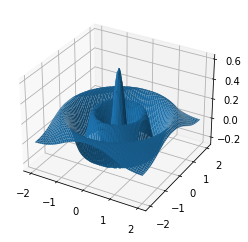

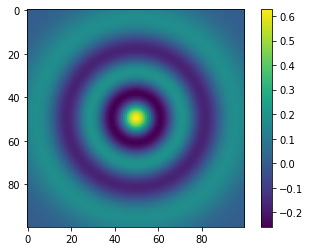

In [15]:
import numpy as np
from plotting import *
from c3.libraries import chip
from c3.c3objs import Quantity as Qty
from c3.model import Model as Mdl
import c3.libraries.hamiltonians as hamiltonians


qubit_levels = 3
qubit_frequency = 7.86e9
qubit_anharm = -264e6
qubit_t1 = 27e-6
qubit_t2star = 39e-6
qubit_temp = 50e-3

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency,min_val=1e9 ,max_val=8e9 ,unit='Hz 2pi'),
    anhar=Qty(value=qubit_anharm,min_val=-380e6 ,max_val=-120e6 ,unit='Hz 2pi'),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    t2star=Qty(value=qubit_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    temp=Qty(value=qubit_temp,min_val=0.0,max_val=0.12,unit='K')
)

resonator_levels = 3
resonator_frequency = 6.02e9
resonator_t1 = 235e-9
resonator_t2star = 39e-6
resonator_temp = 50e-3

parameters_resonator = {
    "freq": Qty(value=resonator_frequency,min_val=0e9 ,max_val=8e9 ,unit='Hz 2pi'),
    "t1": Qty(value=resonator_t1,min_val=100e-9,max_val=1e-6,unit='s'),
    "t2star": Qty(value=resonator_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    "temp": Qty(value=resonator_temp,min_val=0.0,max_val=0.12,unit='K')
}

resonator = chip.Resonator(
    name="R",
    desc="Resonator",
    hilbert_dim=resonator_levels,
    params=parameters_resonator
)

coupling_strength = 130e6
qr_coupling = chip.Coupling(
    name="Q-R",
    desc="coupling",
    comment="Coupling qubit and resonator",
    connected=["Q", "R"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.jaynes_cummings
)

drive_qubit = chip.Drive(
    name="dQ",
    desc="Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drives = [drive_qubit]

model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, qr_coupling]  # Interactions between components
)
model.set_dressed(False)
model.set_lindbladian(False)


psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,1)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

xvec = np.linspace(-2,2,100)
yvec = np.linspace(-2,2,100)

plotWignerFunction([init_state], xvec, yvec)

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

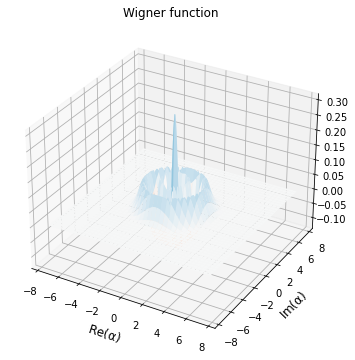

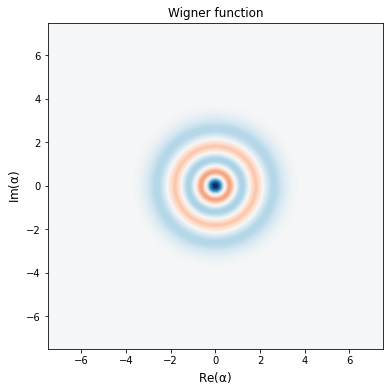

In [16]:
from qutip import *
psi = fock(9,4)
plot_wigner(psi, projection="3d")
plot_wigner(psi, projection="2d")

# IQ Plot while doing the Swap

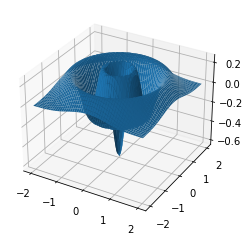

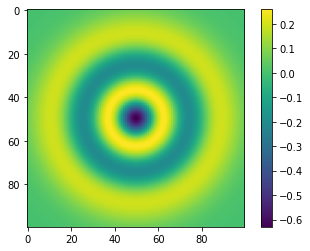

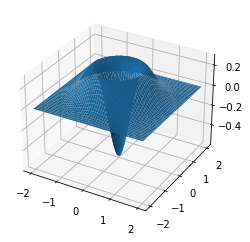

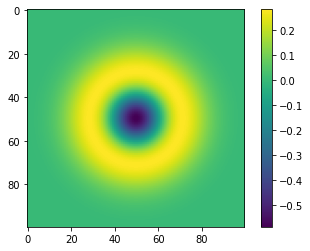

In [14]:
xvec = np.linspace(-2,2,100)
yvec = np.linspace(-2,2,100)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
plotWignerFunction([init_state], xvec, yvec)
plotWignerFunction([tf.matmul(unitaries["swap[0, 1]"], init_state)], xvec, yvec)

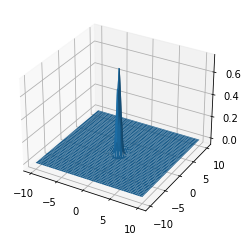

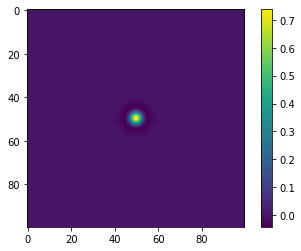

In [19]:
plotIQ(exp, sequence, model.ann_opers[1], frequency=0.0, spacing=100, usePlotly=True)

# To optimize for IQ plane

In [47]:

def IQ_plane_distance(propagators: dict, instructions: dict, index, dims, params, n_eval=-1):
    infids = []
    psi_g = params["ground_state"]
    psi_e = params["excited_state"]
    a_rotated = params["a_rotated"]
    d_max = params["cutoff_distance"]

    for gate, propagator in propagators.items():
        U = tf.matmul(tf.transpose(propagator, conjugate=True),tf.matmul(a_rotated, propagator))
        #instead of calculating the U like this should we just calculate U|psi> and then take the expectation after that
        alpha0 = tf.matmul(tf.matmul(tf.transpose(psi_g, conjugate=True), U),psi_g)[0,0]
        alpha1 = tf.matmul(tf.matmul(tf.transpose(psi_e, conjugate=True), U),psi_e)[0,0]
        distance = tf.abs(alpha0 - alpha1)
        infids.append(tf.exp(-distance/d_max))

    return tf.reduce_mean(infids)
        

In [50]:
propagators = unitaries
instructions = {"Readout": Readout_gate}
index = [0, 1]
dims = (3, 10)

psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))

psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))

freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max
}

IQ_plane_distance(unitaries, instructions, index, dims, params)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5517731606970834>

# Plotting Readout Optimization pulses and dynamics

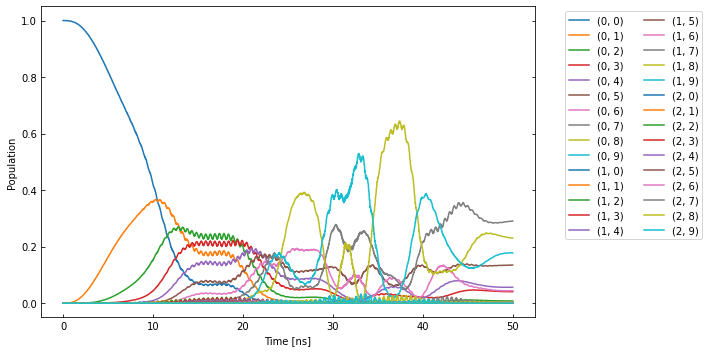

In [81]:
exp = Exp()
exp.read_config("Test_readout_optimization.hjson")
pmap = exp.pmap
model = pmap.model
pmap.load_values("best_point_iq_opt2.txt")
exp = Exp(pmap=pmap)
exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()
sequence = ['Readout[1]']

psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

In [82]:
freq_r = pmap.get_parameter(("Readout[1]", "dR", "carrier", "freq"))
print(freq_r.get_value()/(2*np.pi))

tf.Tensor(6063908676.429606, shape=(), dtype=float64)


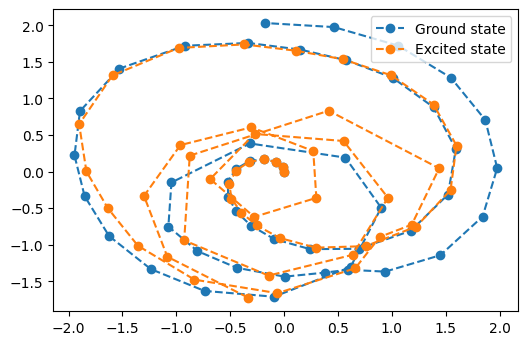

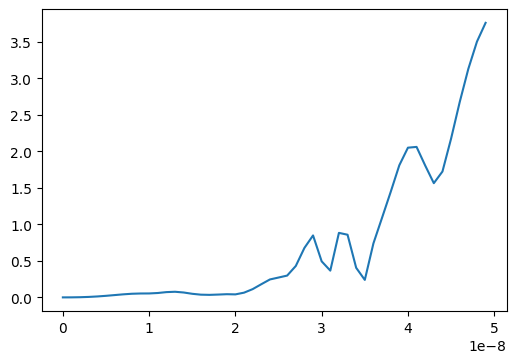

In [83]:
freq_r = pmap.get_parameter(("Readout[1]", "dR", "carrier", "freq")).get_value().numpy()/(2*np.pi)
freq_q = pmap.get_parameter(("Readout[1]", "dQ", "carrier", "freq")).get_value().numpy()/(2*np.pi)
plotIQ(exp, sequence, model.ann_opers[1], freq_q, freq_r, spacing=100, usePlotly=False)

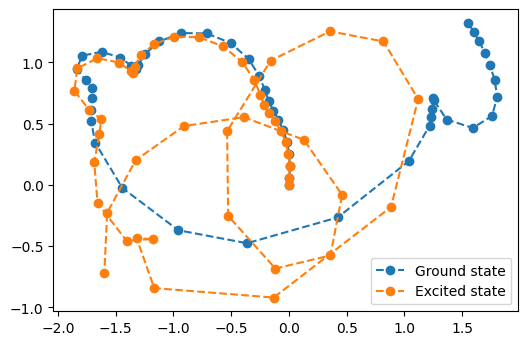

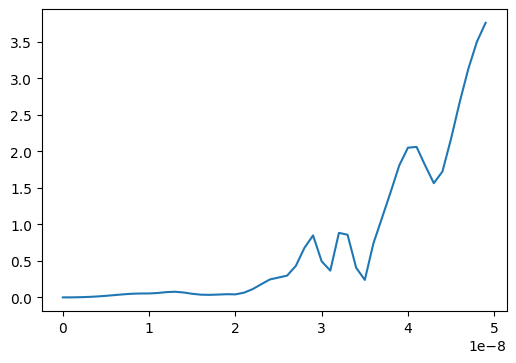

In [64]:
ts = exp.ts
pmap_dict = pmap.asdict()
Q_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["readout-pulse"]
R_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["readout-pulse"]
Q_pulse_shape = Q_pulse.shape(ts, Q_pulse.params)
R_pulse_shape = R_pulse.shape(ts, R_pulse.params)
Q_pulse_shape = Q_pulse_shape* Q_pulse.params["amp"]
R_pulse_shape = R_pulse_shape* R_pulse.params["amp"]


plotIQIdeal(
    exp = exp, 
    sequence = sequence, 
    annihilation_operator= model.ann_opers[1], 
    drive_freq_q= resonator_frequency,
    drive_freq_r= resonator_frequency,
    drive_amp_q = np.ones(len(ts)),#Q_pulse_shape,
    drive_amp_r = np.ones(len(ts)),#R_pulse_shape,
    spacing=100,
    usePlotly=False)

In [47]:
freq_q, freq_r

(5963953553.492784, 6062695982.171352)

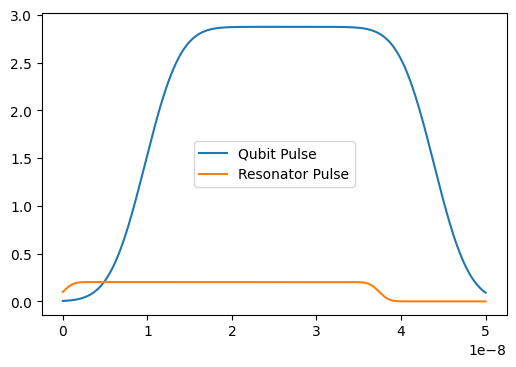

In [65]:
t_total = 50e-9
ts = np.linspace(0, t_total, 10000)

pmap_dict = pmap.asdict()
Q_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["readout-pulse"]
R_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["readout-pulse"]

Q_pulse_carrier = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["carrier"]
R_pulse_carrier = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["carrier"]

Q_pulse_shape = Q_pulse.shape(ts, Q_pulse.params)
R_pulse_shape = R_pulse.shape(ts, R_pulse.params)
Q_pulse_shape = Q_pulse_shape* Q_pulse.params["amp"]
R_pulse_shape = R_pulse_shape* R_pulse.params["amp"]



plt.figure(dpi=100)
plt.plot(ts, Q_pulse_shape, label="Qubit Pulse")
plt.plot(ts, R_pulse_shape, label="Resonator Pulse")

plt.legend()

## Optimize with PWC pulse

/home/ashutos/c3/c3/signal/gates.py:81: UserWarning:

No ideal gate found for gate: Readout

/home/ashutos/c3/c3/signal/gates.py:259: UserWarning:

Length of instruction Readout[1] is fixed, but cuts at least one component. dQ-pwc_pulse is should end @ 50.000 ns , but instruction ends at 5e-08

/home/ashutos/c3/c3/signal/gates.py:259: UserWarning:

Length of instruction Readout[1] is fixed, but cuts at least one component. dR-pwc_pulse is should end @ 50.000 ns , but instruction ends at 5e-08



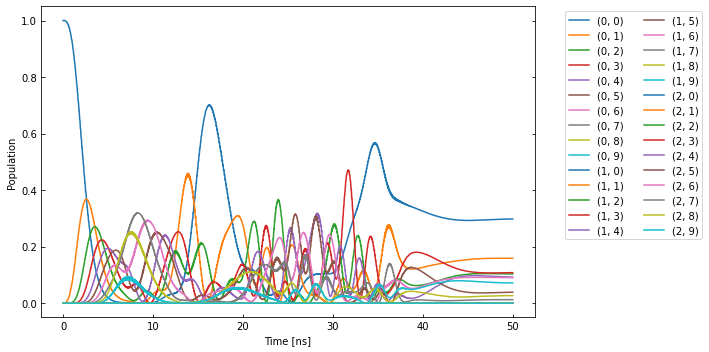

In [80]:
exp = Exp()
exp.read_config("Test_readout_optimization.hjson")
pmap = exp.pmap
model = pmap.model
generator = pmap.generator
pmap.load_values("best_point_iq_opt2.txt")
exp = Exp(pmap=pmap)
exp.set_opt_gates(['Readout[1]'])
model.set_lindbladian(False)
unitaries = exp.compute_propagators()


resonator_frequency = 6.02e9
t_total = 50e-9

ts = exp.ts
pmap_dict = pmap.asdict()

Q_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["readout-pulse"]
R_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["readout-pulse"]

Q_pulse_shape = Q_pulse.shape(ts, Q_pulse.params)
R_pulse_shape = R_pulse.shape(ts, R_pulse.params)
#Q_pulse_shape = Q_pulse_shape* Q_pulse.params["amp"]
#R_pulse_shape = R_pulse_shape* R_pulse.params["amp"]

Q_pulse_carrier = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["carrier"]
R_pulse_carrier = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["carrier"]


Q_pulse_pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_total, min_val=10e-9, max_val=300e-9, unit="s"),
    "inphase": Qty(value=Q_pulse_shape, min_val=0.0, max_val=3.0, unit=""),
    "t_final": Qty(value=t_total, min_val=10e-9, max_val=300e-9, unit="s")
}


Q_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC pulse for Qubit",
    params=Q_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

R_pulse_pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_total, min_val=10e-9, max_val=300e-9, unit="s"),
    "inphase": Qty(value=R_pulse_shape, min_val=0.0, max_val=3.0, unit=""),
    "t_final": Qty(value=t_total, min_val=10e-9, max_val=300e-9, unit="s") 
}


R_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC pulse for resonator",
    params=R_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_total, channels=["dQ", "dR"]
)
Readout_gate.add_component(Q_pwc_pulse, "dQ")
Readout_gate.add_component(Q_pulse_carrier, "dQ")
Readout_gate.add_component(R_pwc_pulse, "dR")
Readout_gate.add_component(R_pulse_carrier, "dR")

readout_gates = [Readout_gate]


parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

model.set_lindbladian(False)
exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

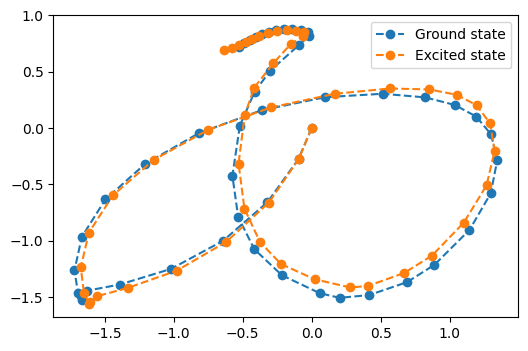

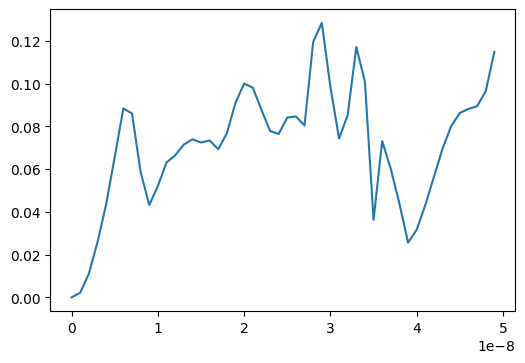

In [79]:
"""
ts = exp.ts
pmap_dict = pmap.asdict()
Q_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dQ"]["pwc_pulse"]
R_pulse = pmap_dict["Readout[1]"]["drive_channels"]["dR"]["pwc_pulse"]
Q_pulse_shape = Q_pulse.shape(ts, Q_pulse.params)
R_pulse_shape = R_pulse.shape(ts, R_pulse.params)
Q_pulse_shape = Q_pulse_shape* Q_pulse.params["amp"]
R_pulse_shape = R_pulse_shape* R_pulse.params["amp"]
"""

plotIQIdeal(
    exp = exp, 
    sequence = sequence, 
    annihilation_operator= model.ann_opers[1], 
    drive_freq_q= resonator_frequency,
    drive_freq_r= resonator_frequency,
    drive_amp_q = np.ones(len(ts)),#Q_pulse_shape,
    drive_amp_r = np.ones(len(ts)),#R_pulse_shape,
    spacing=100,
    usePlotly=False)